# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from pmdarima import auto_arima
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# Load the dataset

In [ ]:
data = pd.read_csv('BTC-USD.csv')

# Convert dates and set as index


In [ ]:
# Data Preparation
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data.set_index('Date', inplace=True)
data = data.sort_index()

# Resample data to weekly frequency


In [ ]:
data = data.resample('W').mean()

# Handle missing values


In [ ]:
data.fillna(method='ffill', inplace=True)

# Exploratory Data Analysis (EDA)


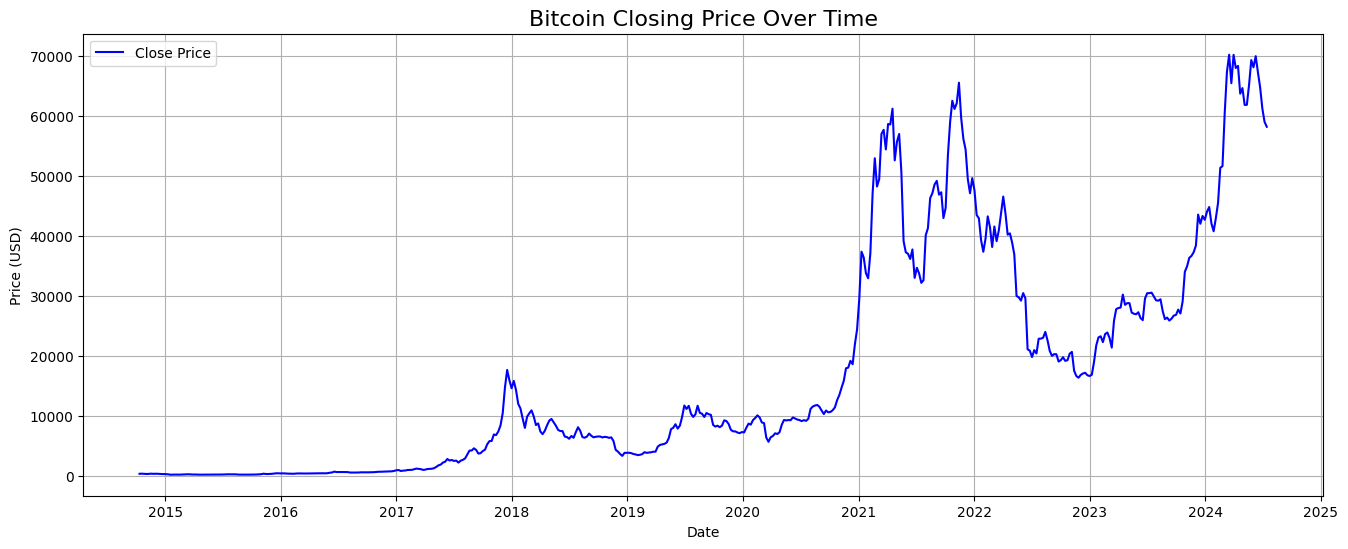

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(data['Close'], color='blue', label='Close Price')
plt.title('Bitcoin Closing Price Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Trading Volume Analysis


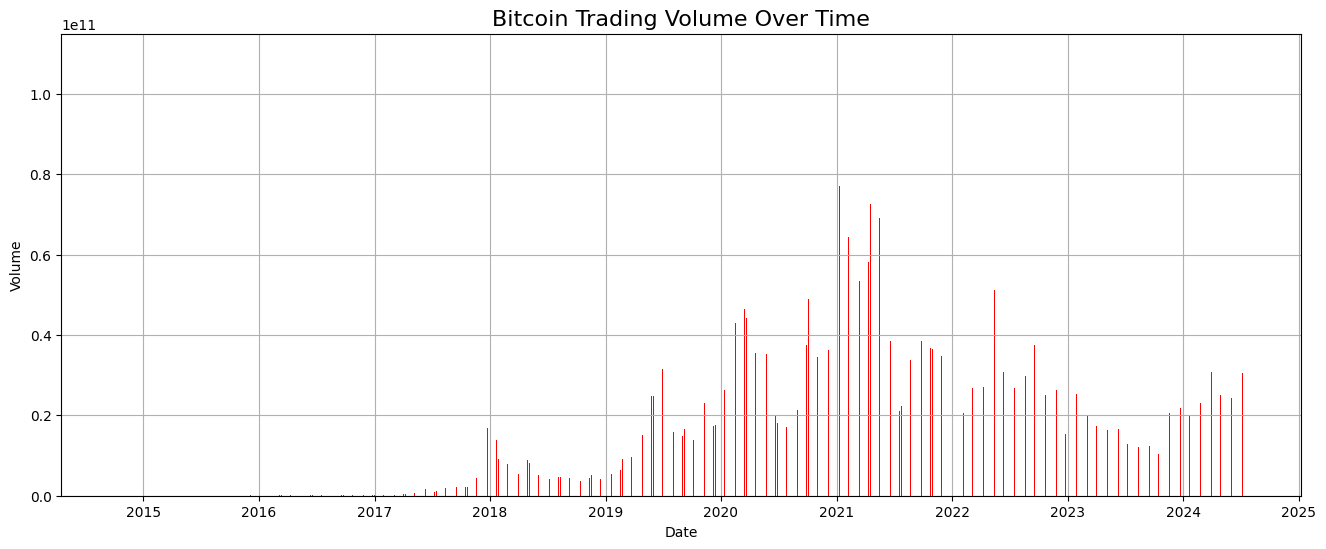

In [ ]:
plt.figure(figsize=(16, 6))
plt.bar(data.index, data['Volume'], color='red',)
plt.title('Bitcoin Trading Volume Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

# Heatmap for Feature Correlation


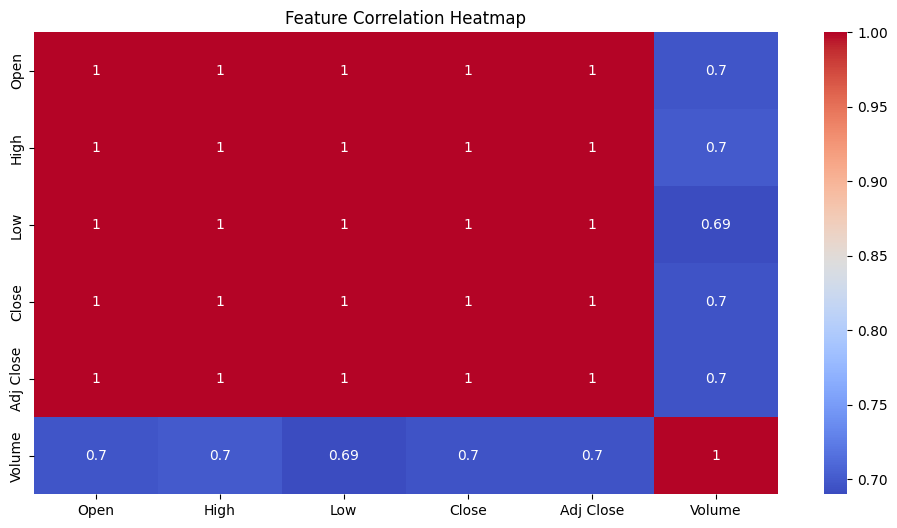

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Feature Engineering with Volatility Features


In [ ]:
data['7_day_MA'] = data['Close'].rolling(window=7).mean()
data['30_day_MA'] = data['Close'].rolling(window=30).mean()
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = 100 - (100 / (1 + data['Close'].pct_change().rolling(14).mean()))
data['Price Change %'] = data['Close'].pct_change()
data['Rolling_Std_7'] = data['Close'].rolling(window=7).std()
data['Rolling_Std_30'] = data['Close'].rolling(window=30).std()
data['Upper_Band'] = data['7_day_MA'] + (2 * data['Rolling_Std_7'])
data['Lower_Band'] = data['7_day_MA'] - (2 * data['Rolling_Std_7'])
data.dropna(inplace=True)

# Scaling the data


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Create sequences for LSTM


In [ ]:
X, y = [], []
sequence_length = 60  # Last 60 days for prediction
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])
    
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # LSTM expects 3D input

# Split data into training and testing


In [ ]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# --- Hyperparameter Tuning ---


# ARIMA Hyperparameter Tuning


In [ ]:
train_arima = data['Close'][:train_size]
test_arima = data['Close'][train_size:]
model_arima = auto_arima(train_arima, seasonal=False, trace=True, suppress_warnings=True)
forecast_arima = model_arima.predict(n_periods=len(test_arima))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5888.318, Time=2.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5916.617, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5902.887, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5901.035, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5916.788, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5904.976, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5904.366, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5888.938, Time=1.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5892.020, Time=0.84 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5903.002, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5899.164, Time=0.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5898.957, Time=0.84 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5886.298, Time=0.63 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5893.530, Time=0.40 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept

# SARIMA Hyperparameter Tuning


In [ ]:
model_sarima = auto_arima(train_arima, seasonal=True, m=12, trace=True, suppress_warnings=True)
forecast_sarima = model_sarima.predict(n_periods=len(test_arima))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5891.105, Time=4.75 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5916.617, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5904.389, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5902.997, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5916.788, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5890.289, Time=1.81 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5888.318, Time=1.35 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5890.279, Time=2.05 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=5904.976, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=5904.366, Time=0.71 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=5888.938, Time=2.77 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=5892.020, Time=1.91 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=5903.002, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=5899.164, Time=0.81 sec
 ARIMA(3,1,1)(0,0,0

# Gradient Boosting Regressor Hyperparameter Tuning


In [ ]:
X_gbr = np.arange(len(data)).reshape(-1, 1)
train_gbr, test_gbr = X_gbr[:train_size], X_gbr[train_size:]
y_gbr = data['Close'].values

params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

model_gbr = GradientBoostingRegressor()
grid_gbr = GridSearchCV(model_gbr, params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_gbr.fit(train_gbr, y_gbr[:train_size])
forecast_gbr = grid_gbr.predict(test_gbr)

# LSTM Model


In [ ]:
model_lstm = Sequential([
    Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    Bidirectional(LSTM(units=50, return_sequences=False)),
    Dropout(0.3),
    Dense(units=1)
])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

predictions_lstm = model_lstm.predict(X_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0759 - val_loss: 0.0421
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0173 - val_loss: 0.0066
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0085 - val_loss: 0.0090
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0063 - val_loss: 0.0189
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0066 - val_loss: 0.0042
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0072 - val_loss: 0.0128
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0046 - val_loss: 0.0061
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0048 - val_loss: 0.0087
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

# --- Performance Evaluation Function ---


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f'--- {model_name} ---')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'MAPE: {mape:.2f}%\n')

# Evaluate Models


In [ ]:
evaluate_model(test_arima, forecast_arima, "ARIMA")
evaluate_model(test_arima, forecast_sarima, "SARIMA")
evaluate_model(y_test_actual, predictions_lstm, "LSTM")
evaluate_model(test_arima, forecast_gbr, "Gradient Boosting Regressor")


--- ARIMA ---
RMSE: 17493.68
MAE: 15451.48
MAPE: 55.91%

--- SARIMA ---
RMSE: 17117.02
MAE: 15025.34
MAPE: 53.76%

--- LSTM ---
RMSE: 3994.02
MAE: 2992.40
MAPE: 7.98%

--- Gradient Boosting Regressor ---
RMSE: 17609.37
MAE: 15581.59
MAPE: 56.51%



# --- Visualize Predictions ---


# ARIMA Predictions


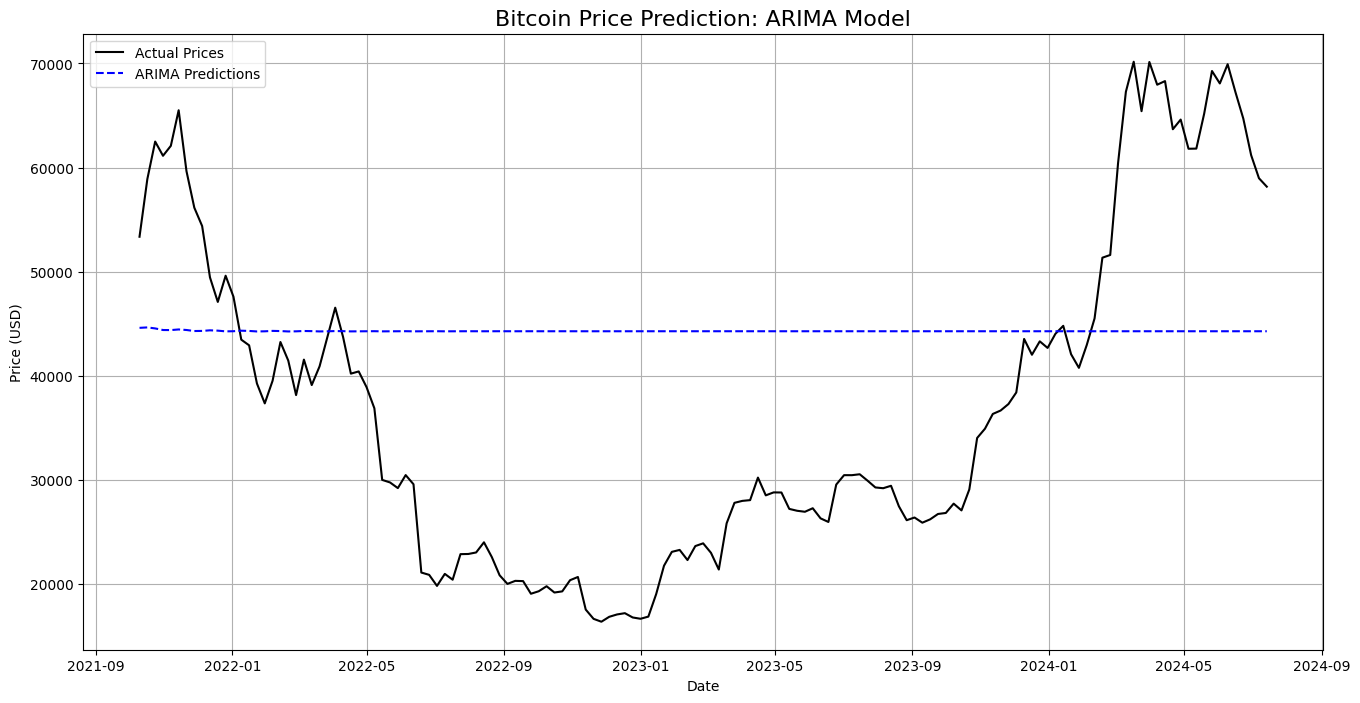

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(test_arima.index[:len(forecast_arima)], test_arima[:len(forecast_arima)], label='Actual Prices', color='black')
plt.plot(test_arima.index[:len(forecast_arima)], forecast_arima, label='ARIMA Predictions', linestyle='dashed', color='blue')
plt.title('Bitcoin Price Prediction: ARIMA Model', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# SARIMA Predictions


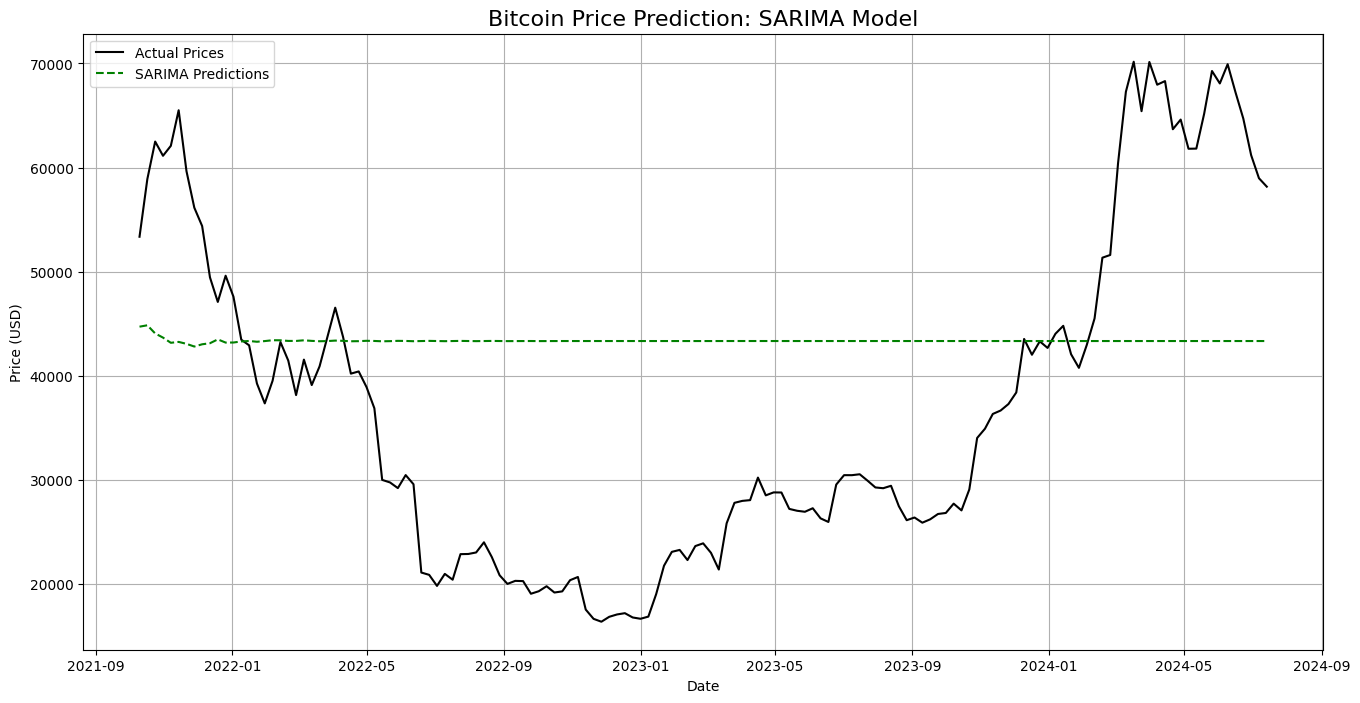

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(test_arima.index[:len(forecast_sarima)], test_arima[:len(forecast_sarima)], label='Actual Prices', color='black')
plt.plot(test_arima.index[:len(forecast_sarima)], forecast_sarima, label='SARIMA Predictions', linestyle='dashed', color='green')
plt.title('Bitcoin Price Prediction: SARIMA Model', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# LSTM Predictions


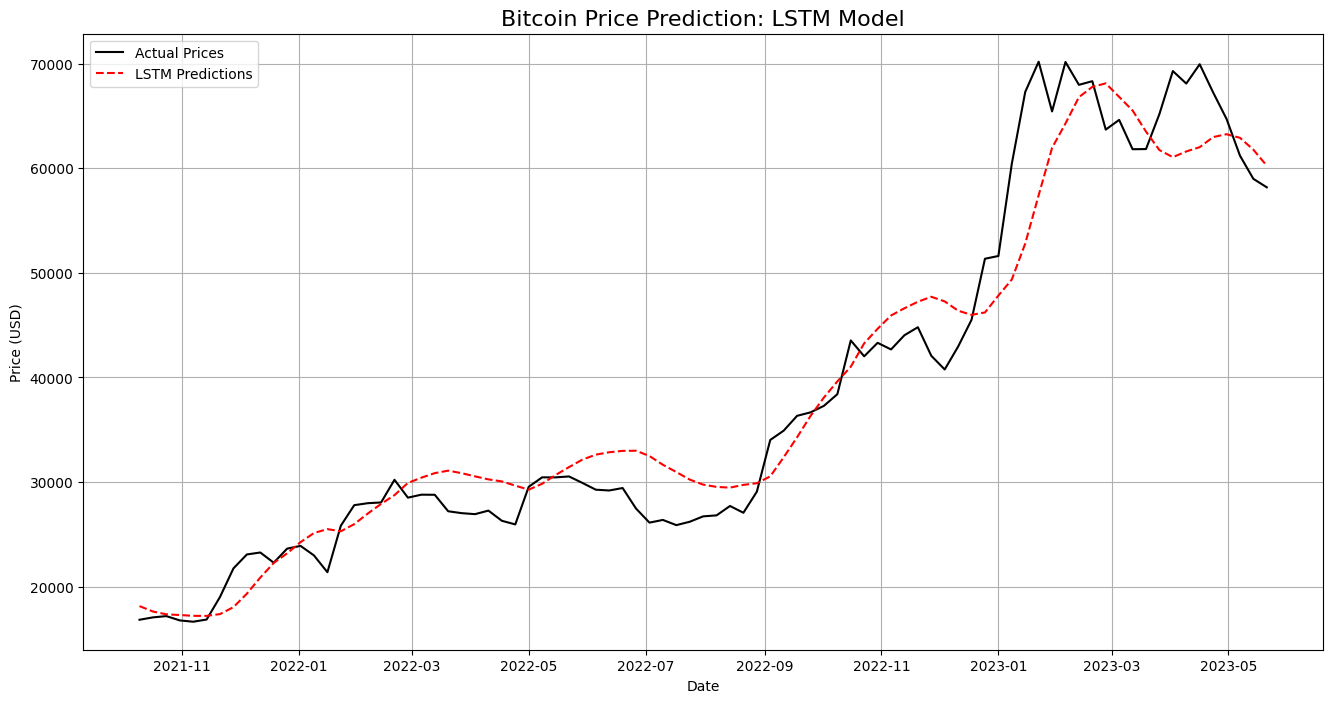

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(test_arima.index[:len(predictions_lstm)], y_test_actual[:len(predictions_lstm)], label='Actual Prices', color='black')
plt.plot(test_arima.index[:len(predictions_lstm)], predictions_lstm, label='LSTM Predictions', linestyle='dashed', color='red')
plt.title('Bitcoin Price Prediction: LSTM Model', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# GBR Predictions


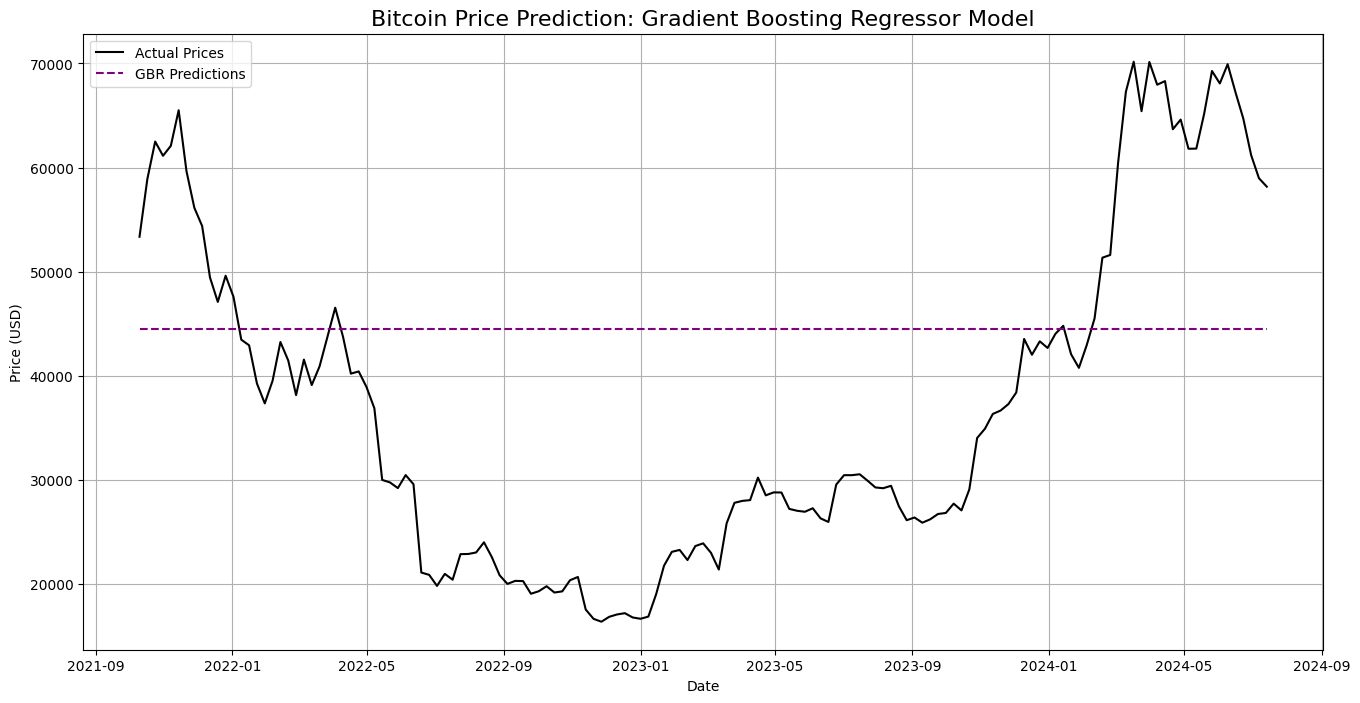

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(test_arima.index[:len(forecast_gbr)], test_arima[:len(forecast_gbr)], label='Actual Prices', color='black')
plt.plot(test_arima.index[:len(forecast_gbr)], forecast_gbr, label='GBR Predictions', linestyle='dashed', color='purple')
plt.title('Bitcoin Price Prediction: Gradient Boosting Regressor Model', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()